In [4]:
#!pip uninstall huetracer -y
#!pip install huetracer
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import pandas as pd
import scvi
import gc
import math
import bin2cell as b2c
import torch
from itertools import cycle
from sklearn.neighbors import NearestNeighbors
import importlib
import gdown
import zipfile
import adjustText as at
import scipy
import huetracer
import plotly.graph_objects as go
importlib.reload(huetracer)

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

scvi.settings.seed = 0
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else"mps" if torch.backends.mps.is_available() else "cpu")
device_str = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Seed set to 0


Using device: mps


In [5]:
### parameters to be input
SAMPLE_NAME = 'G1'
lib_id = SAMPLE_NAME # list(sp_adata.uns['spatial'].keys())[0]

path = os.path.expanduser("~")+"/Desktop/space/GCTB_bin2cell"
save_path_for_today = os.path.expanduser("~")+"/tmp/outputs/250610_" + SAMPLE_NAME
source_image_path = "../VisiumHD/image/microscope_image/" + SAMPLE_NAME + ".tif"

### ligand-receptor data obtained from nichenet, download only once
# # 1. Google Drive link URL
# url = "https://drive.google.com/uc?export=download&id=1pMpGUfsrDNWmZ_osfSglX5MrL8e8vOeA"
# # 2. File name
# output = "ligand_target_df.csv.zip"
# # 3. Download
# gdown.download(url, output, quiet=False)
# # 4. ZIP file extraction
# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall("ligand_target_df")

# 5. Set your path
file_nichenet = '../GCTB_bin2cell/data/tutorial/ligand_target_df.csv'

# area to be analyzed
# ## GCTB spatial G1, FFPE9
mask_large_x1, mask_large_x2, mask_large_y1, mask_large_y2 = 450, 1950, 250, 1750

# List of target gene names
target_genes = [
    'TNFSF11', 'LIF', 'TNFRSF11A', 'LIFR',
    'CTSK', 'CTSB', 'LMNB1', 'MEGF10',
    'MMP9', 'MMP13', 'SPP1', 'GRN',
    'NOTCH3', 'SDC2', 'TIMP1', 'SPARC',
    'ACP5'
    # Add more genes here if needed
]

annotation_dict = {
    'C0':  'Tumor',
    'C1':  'Tumor',
    'C2':  'Tumor',
    'C3':  'Monocyte',
    'C4':  'Tumor',
    'C5':  'Lymphocyte',
    'C6':  'Endothelial',
    'C7':  'Monocyte',
    'C8':  'CAFibroblast',
    'C9':  'GiantCell',
    'C10': 'GC_proliferating',
    'C11': 'GiantCell',
    'C12': 'Tumor',
    'C13': 'Tumor',
    'C14': 'Doublet',
    'C15': 'Doublet',
    'C16': 'Tumor',
    'C17': 'Monocyte',
    'C18': 'Doublet',
    'C19': 'Tumor',
    'C20': 'Monocyte',
    'C21': 'Tumor',
    'C22': 'Tumor'
}

target_cell_type = annotation_dict['C0'] # Simply select a single cell type as cluster number
# target_cell_type = 'Airway epithelial cells (CAPN8+, ELF3+)' # 'Tumor', 'GiantCell', etc., replace with your desired CellType

Gene_to_analyze = "LIF"
# Gene_to_analyze = "CSF1"

# Definition of neighborhood cells
neighbor_cell_numbers = 19

#role = 'sender'
role = 'receiver'
each_display_num = 3

# Volcano plot of gene expression between clusters
group1_environments = ['0', '2'] # Microenvironmentのカテゴリ名。文字列で定義
group2_environments = ['1', '3'] # Microenvironmentのカテゴリ名。文字列で定義

# setting for filenames
label_image_filename = "he_labels_image.pdf"
h5ad_filename = SAMPLE_NAME + "_b2c.h5ad"
h5ad_full_filename = SAMPLE_NAME + "_2um.h5ad"
h5ad_predicted_full_filename = SAMPLE_NAME + "_nucleus_predicted.h5ad"
h5ad_sc_filtered_full_filename = SAMPLE_NAME + "_single_cell_filtered.h5ad"
h5ad_sc_microenvironment_full_filename = SAMPLE_NAME + "_single_cell_microenvironment.h5ad"
save_spatial_plot_path = os.path.join(save_path_for_today, "cropped_spatial_plot.svg")
save_svg_path = os.path.join(save_path_for_today, "spatial_salvage_labels.svg")
h5ad_save_path = os.path.join(save_path_for_today, h5ad_filename)
h5ad_full_save_path = os.path.join(save_path_for_today, h5ad_full_filename)
h5ad_predicted_full_save_path = os.path.join(save_path_for_today, h5ad_predicted_full_filename)
h5ad_sc_filtered_full_save_path = os.path.join(save_path_for_today, h5ad_sc_filtered_full_filename)
h5ad_microenvironment_full_save_path = os.path.join(save_path_for_today, h5ad_sc_microenvironment_full_filename)

os.chdir(path)
os.makedirs(save_path_for_today, exist_ok=True)


anndata.py (602): You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
2840309143.py (11): Modifying `X` on a view results in data being overridden


_normalization.py (216): Received a view of an AnnData. Making a copy.
_highly_variable_genes.py (73): `flavor='seurat_v3'` expects raw count data, but non-integers were found.
_normalization.py (216): Received a view of an AnnData. Making a copy.


Device: mps
細胞数: 50,445
遺伝子数: 516
k-NN検索を実行中...
微小環境データを構築中...


100%|██████████████████████████████████████████████████████████████████████████████████████| 50445/50445 [00:00<00:00, 84703.82it/s]


微小環境データ形状: (50445, 516)
VAEの訓練を開始...
Epoch 1000/1000, Loss: 284.5382 (Rec: 251.8011, KL: 32.7371) [Elapsed: 05:39, Est. Remaining: 00:00]   潜在特徴量を抽出中...
潜在特徴量形状: (50445, 32)
AnnDataオブジェクトを作成中...
データの前処理中...
近傍グラフ構築中...
UMAP次元削減実行中...
Leidenクラスタリング実行中...


vae.py (289): In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


クラスター数: 13


基本的なUMAP可視化:


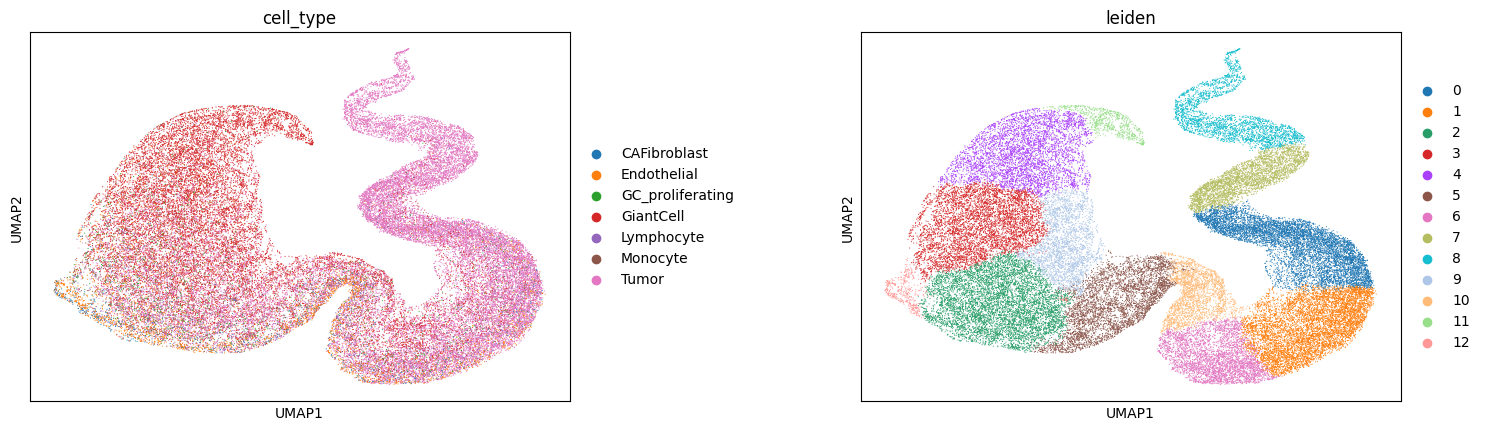

クラスタ数: 13


Cell type数: 7


2840309143.py (75): Use `squidpy.pl.spatial_scatter` instead.


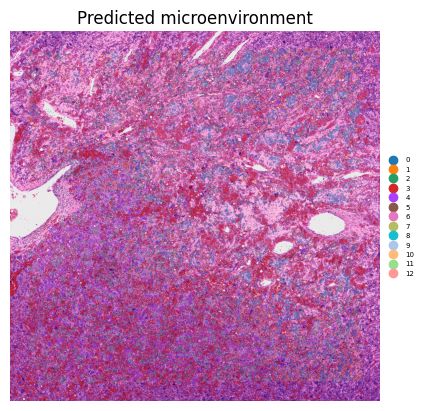

In [6]:
# Microenvironment estimation with variational autoencoder, gene expression data of 18 cells around the center cell was used.
sp_adata_predicted = sc.read_h5ad(h5ad_predicted_full_save_path)

# === Preprocessing ===
cell_mask = ((sp_adata_predicted.obs['array_row'] >= mask_large_x1) & 
             (sp_adata_predicted.obs['array_row'] <= mask_large_x2) & 
             (sp_adata_predicted.obs['array_col'] >= mask_large_y1) & 
             (sp_adata_predicted.obs['array_col'] <= mask_large_y2)
            )
sp_adata_microenvironment = sp_adata_predicted.copy()[cell_mask]
sp_adata_microenvironment.X = sp_adata_microenvironment.raw.X.copy()

# 1. Cell count by cell labels
group_counts = sp_adata_microenvironment.obs['scvi_predicted_labels'].value_counts()
valid_groups = group_counts[group_counts > 1].index.tolist()

# 2. Exclude cell types with only 1 cell count
filtered_adata = sp_adata_microenvironment.copy()[
    sp_adata_microenvironment.obs['scvi_predicted_labels'].isin(valid_groups)
]
sc.pp.normalize_total(filtered_adata, target_sum = 1e6)
sc.pp.log1p(filtered_adata)

filtered_adata.raw = None

# 3. Select genes with DEG analysis
sc.tl.rank_genes_groups(
    filtered_adata,
    # groupby='scvi_predicted_labels',
    groupby='predicted_cell_type',
    #groupby='leiden_nucleus',
    method='wilcoxon',
    n_genes=100
)

top_genes_df = pd.DataFrame(filtered_adata.uns['rank_genes_groups']['names'])
top_genes_list = top_genes_df.values.flatten().tolist()
top_genes_list = [g for g in top_genes_list if pd.notnull(g)]
common_hvg = list(set(top_genes_list))
common_hvg = [g for g in common_hvg if g in filtered_adata.var_names]

sc.pp.highly_variable_genes(filtered_adata, n_top_genes=100, flavor='seurat_v3')
ref_hvg_100 = filtered_adata.var[filtered_adata.var['highly_variable']].index.tolist()
all_genes = set(common_hvg) | \
            set(ref_hvg_100)
final_gene_list = [g for g in all_genes if g in sp_adata_microenvironment.var_names]

sc.pp.normalize_total(sp_adata_microenvironment, target_sum = 1e0)
sp_adata_microenvironment = sp_adata_microenvironment[:, final_gene_list].copy()
coords = sp_adata_microenvironment.obs[["array_row", "array_col"]].values
X = sp_adata_microenvironment.X.toarray() if hasattr(sp_adata_microenvironment.X, "toarray") else sp_adata_microenvironment.X  # shape: (n_cells, n_genes)
data_min = X.min()
data_max = X.max()
X = (X - data_min) / (data_max - data_min)
cell_types = sp_adata_microenvironment.obs['predicted_cell_type']
#cell_types = sp_adata_microenvironment.obs['cluster_cell_type']

print(f"Device: {device}")

# analysis
analyzer = huetracer.SpatialMicroenvironmentAnalyzer(coords, X, k_neighbors=neighbor_cell_numbers)
indices, microenv_data = analyzer.build_microenvironment_data()
vae_model = analyzer.train_vae(latent_dim=32, epochs=1000, batch_size=16384, lr=4e-4, dim_1 = 128, dim_2 = 128, weight_decay=1e-4, beta=1)
analyzer.extract_latent_features()
umap_embedding, clusters = analyzer.perform_umap_clustering(cell_type_data=cell_types)
# visualization
analyzer.visualize_results()
analyzer.visualize_scanpy_results()

huetracer.plot_all_clusters_highlights(analyzer)
huetracer.plot_all_cell_type_highlights(analyzer)

sp_adata_microenvironment.obs['predicted_microenvironment'] = analyzer.adata.obs['leiden'].astype(str).to_numpy()

sc.pl.spatial(
    sp_adata_microenvironment,
    color='predicted_microenvironment',
    title='Predicted microenvironment',
    size=20,
    img_key='hires',
    legend_fontsize=5,
    spot_size=1,
    frameon=False
)

selected_cells = sp_adata_microenvironment

# ---------- 2. hires座標計算 ----------
sf_hires = selected_cells.uns["spatial"][lib_id]["scalefactors"]["tissue_hires_scalef"]
xy = (
    pd.DataFrame(selected_cells.obsm["spatial"] * sf_hires, columns=["x", "y"], index=selected_cells.obs_names)
    .join(selected_cells.obs["object_id"])
    .reset_index()
    .rename(columns={"index": "cell_id"})
)
merged = xy.merge(selected_cells.obs, on="object_id", how="inner")
merged["predicted_microenvironment"] = clusters
merged["group"] = merged["predicted_microenvironment"]

# ---------- 5. 色マッピング ----------
group_order = sorted(merged["group"].dropna().unique())
hires_img = selected_cells.uns["spatial"][lib_id]["images"]["hires"]
h, w = hires_img.shape[:2]

# マーカー形状リスト（Seabornで使えるmatplotlibのmarker）
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'P', 'H', '8', 'd', '|']
# カラーパレットを増強（例："tab20"）
palette = sns.color_palette("tab20", n_colors=len(group_order))

# 色とマーカーの辞書作成
color_map = dict(zip(group_order, palette))
marker_cycle = cycle(markers)
marker_map = {group: next(marker_cycle) for group in group_order}

# 描画
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(hires_img, extent=[0, w, h, 0])

# クラスタごとに個別に描画（scatterplotではなくplotを使う）
for group in group_order:
    data_sub = merged[merged["group"] == group]
    ax.scatter(
        data_sub["x"],
        data_sub["y"],
        c=[color_map[group]],
        marker=marker_map[group],
        s=0.5,           # 点のサイズ（調整可能）
        alpha=0.5,
        label=group,
        linewidths=0,
        rasterized=True
    )

ax.invert_yaxis()
ax.set_axis_off()

# 凡例を調整
ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    title="Grouped Cell Type",
    markerscale=8,
    frameon=False,
    fontsize=6
)

# ---------- 7. 保存 ----------
filename = SAMPLE_NAME + "_overlay_hires_by_microenvironment.pdf"
out_pdf = os.path.join(save_path_for_today, filename)
fig.savefig(out_pdf, format="pdf", dpi=1000, bbox_inches="tight")
plt.close(fig)
sp_adata_microenvironment.write_h5ad(h5ad_microenvironment_full_save_path)

1694789643.py (51): The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
1694789643.py (58): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

1694789643.py (51): The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
1694789643.py (58): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

1694789643.py (51): The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

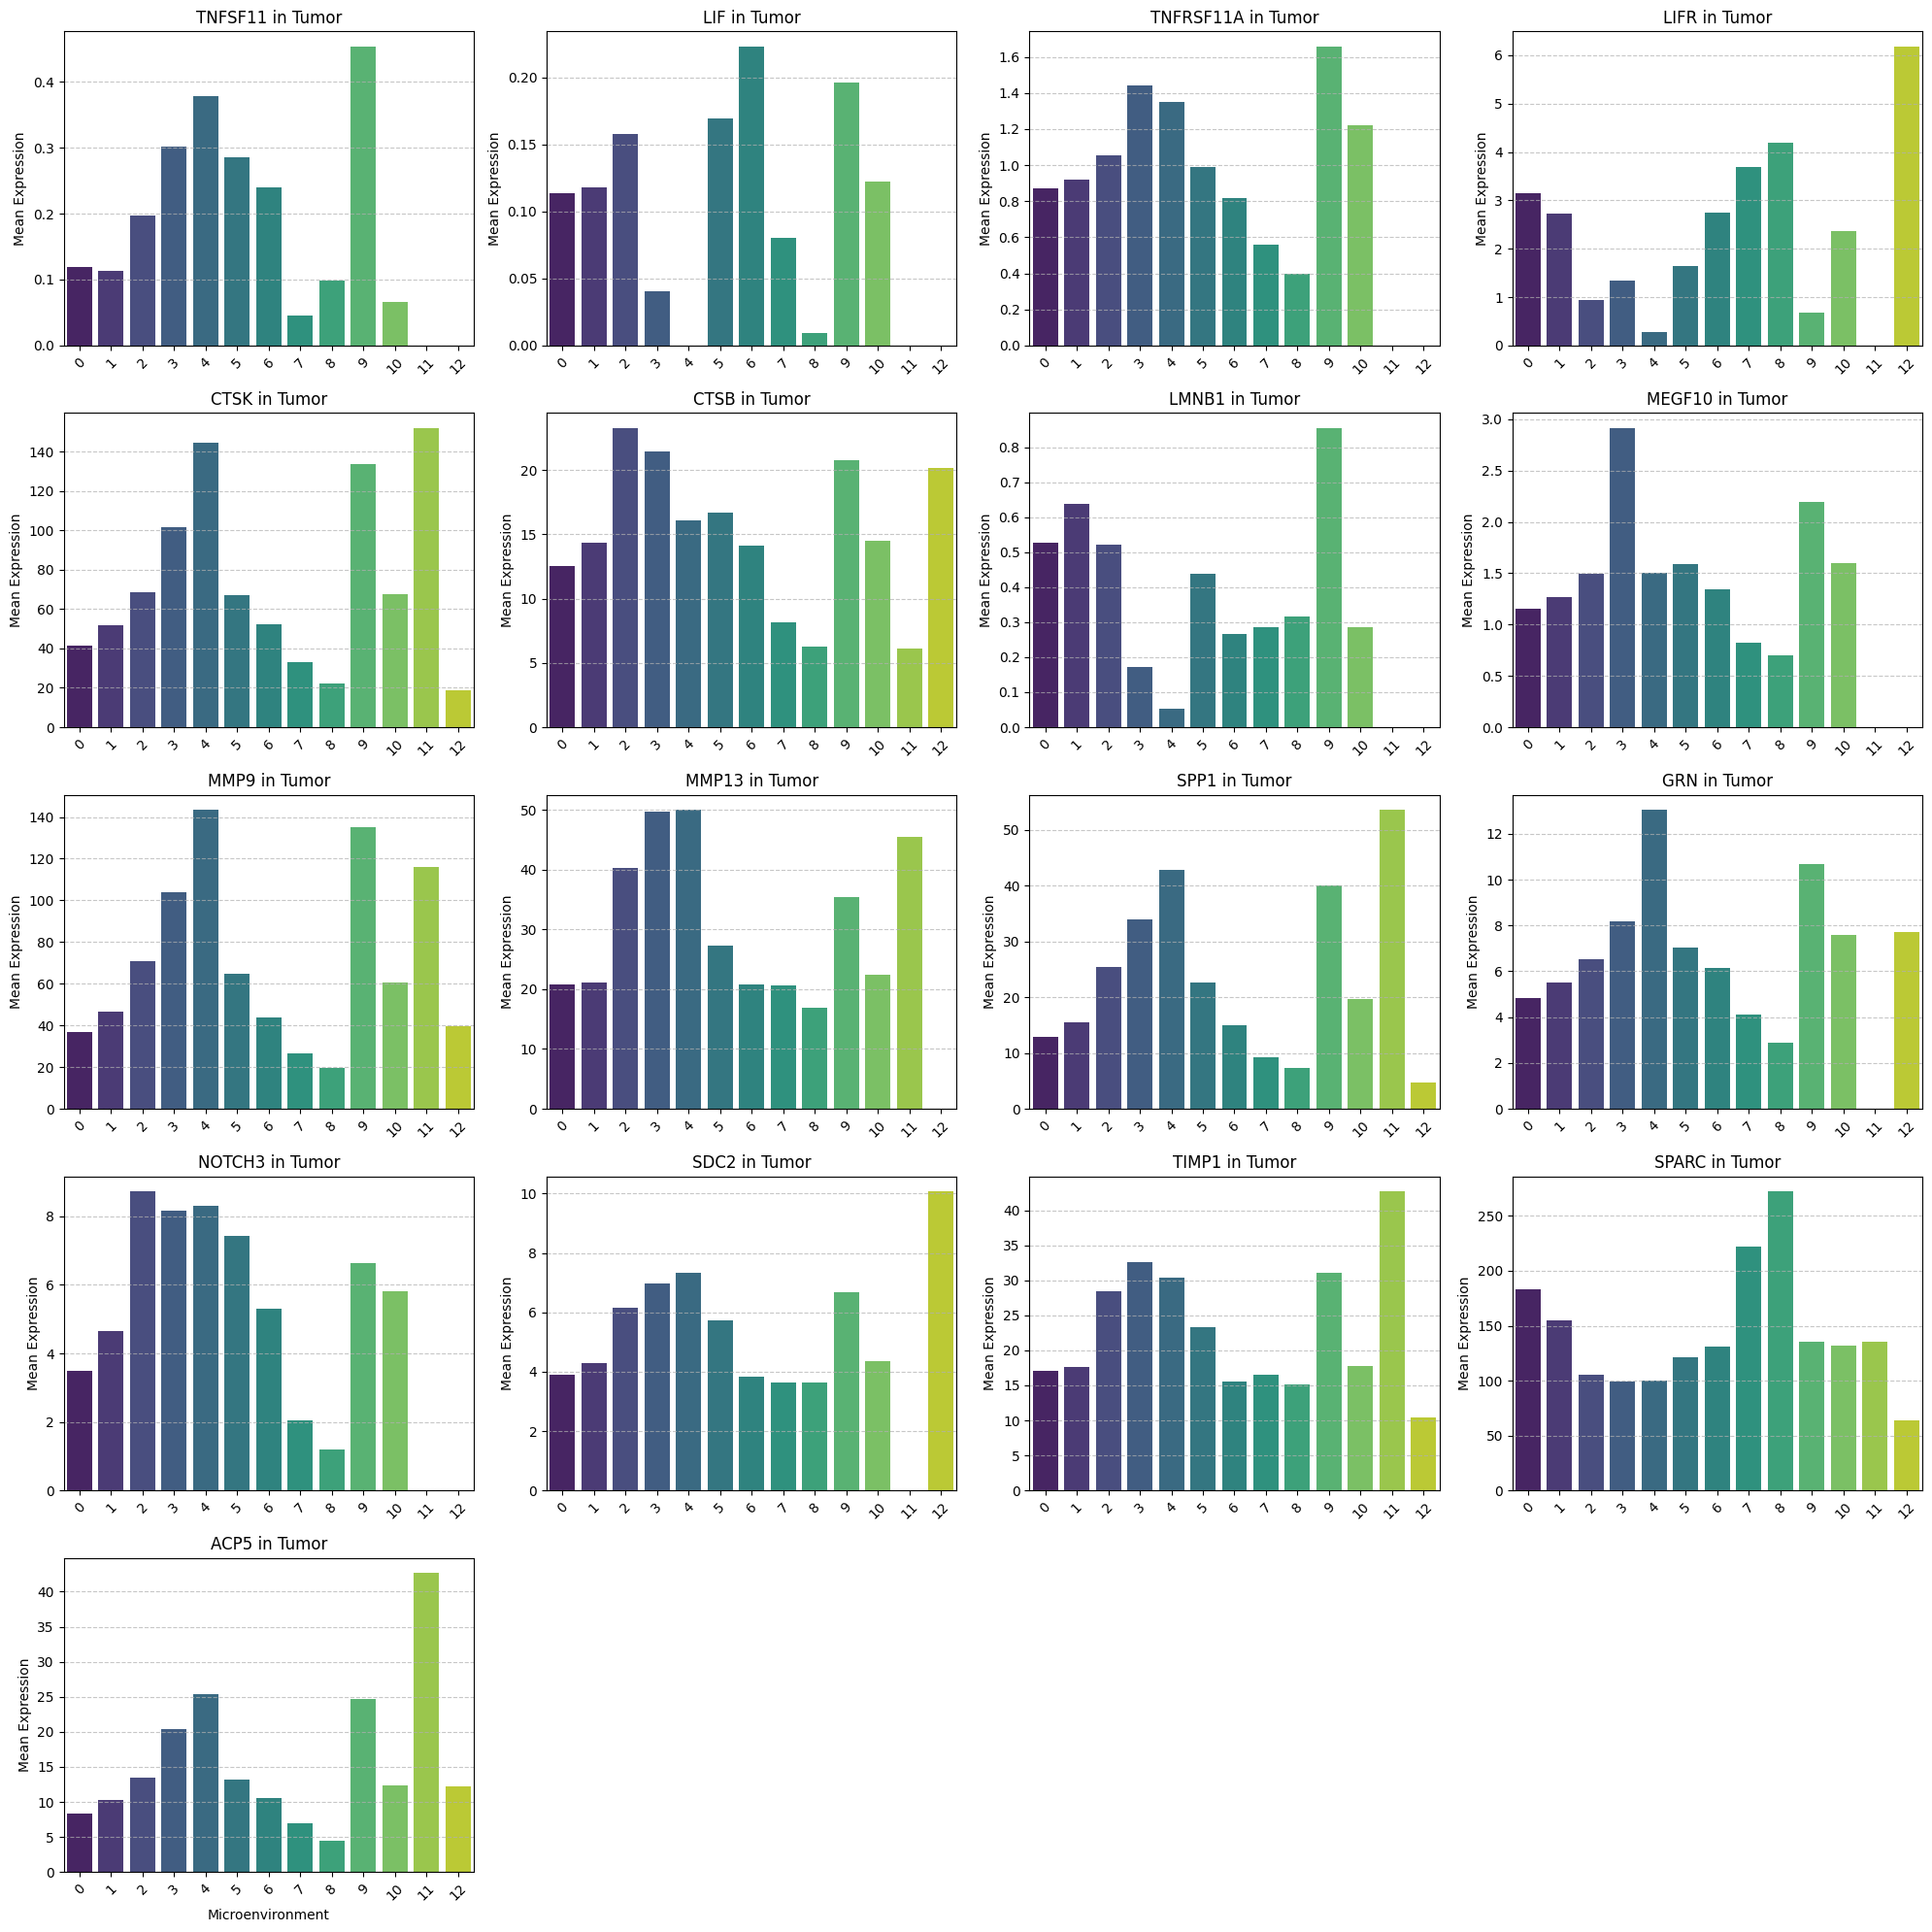

Analysis complete for cell type: Tumor


In [7]:
# Visualizaion of gene expression per cluster
# Specify the cluster_cell_type to visualize

sp_adata_raw = sc.read_h5ad(h5ad_save_path)
sp_adata_microenvironment = sc.read_h5ad(h5ad_microenvironment_full_save_path)
cell_mask = ((sp_adata_raw.obs['array_row'] >= mask_large_x1) & 
             (sp_adata_raw.obs['array_row'] <= mask_large_x2) & 
             (sp_adata_raw.obs['array_col'] >= mask_large_y1) & 
             (sp_adata_raw.obs['array_col'] <= mask_large_y2)
            )
sp_adata = sp_adata_raw.copy()[cell_mask]
# common cell IDs
common_cells = sp_adata_microenvironment.obs_names.intersection(sp_adata.obs_names)
sp_adata = sp_adata_raw[common_cells].copy()
sp_adata.obs["predicted_cell_type"] = sp_adata_microenvironment.obs["predicted_cell_type"]
sp_adata.obs["predicted_microenvironment"] = sp_adata_microenvironment.obs["predicted_microenvironment"]
sc.pp.normalize_total(sp_adata, target_sum=1e4)

# 1. Filter cells belonging to the selected cluster_cell_type
filtered_adata = sp_adata[
    sp_adata.obs['predicted_cell_type'] == target_cell_type
].copy()

# Add expression data for all target genes to filtered_adata.obs
# Efficiently handles sparse matrices
gene_expression_df = pd.DataFrame(
    filtered_adata[:, target_genes].X.toarray(),
    index=filtered_adata.obs.index,
    columns=target_genes
)
filtered_adata.obs = pd.concat([filtered_adata.obs, gene_expression_df], axis=1)

# 2. Set up the subplot layout
n_genes = len(target_genes)
ncols = 4
nrows = (n_genes + ncols - 1) // ncols # Calculate required number of rows (ceil division)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), sharex=False, sharey=False)
axes = axes.flatten() # Flatten axes to a 1D array for easier iteration

# Loop through each gene and plot its bar graph
for i, target_gene in enumerate(target_genes):
    if i >= len(axes): # Break if we exceed the number of subplots
        break

    ax = axes[i] # Current subplot axis

    # Calculate mean and standard deviation for the current gene per predicted_microenvironment
    gene_exp_col = target_gene

    plot_data_gene = filtered_adata.obs.groupby('predicted_microenvironment')[gene_exp_col].agg(['mean', 'std']).reset_index()
    plot_data_gene.rename(columns={'mean': 'mean_expression', 'std': 'std_expression'}, inplace=True)

    # Replace NaN standard deviation (e.g., if a group has only one cell) with 0 to avoid errors
    plot_data_gene['std_expression'] = plot_data_gene['std_expression'].fillna(0)

    # 3. Plot the bar graph
    sns.barplot(
        x='predicted_microenvironment',
        y='mean_expression',
        data=plot_data_gene,
        # yerr=plot_data_gene['std_expression'], # Specify standard deviation as error bars
        capsize=0.1,
        palette='viridis',
        ax=ax # Specify which subplot to draw on
    )

    ax.set_title(f'{target_gene} in {target_cell_type}')
    # Only show x-axis label for the bottom row plots
    ax.set_xlabel('Microenvironment' if i >= (nrows - 1) * ncols else '')
    ax.set_ylabel('Mean Expression')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # Corrected: Use labelrotation instead of ha for tick_params
    ax.tick_params(axis='x', labelrotation=45) # Rotate x-axis labels for readability

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust spacing between subplots
plt.show()

print(f"Analysis complete for cell type: {target_cell_type}")


Unique cell types in sp_adata: ['Lymphocyte', 'Tumor', 'GiantCell', 'Monocyte', 'Endothelial', 'CAFibroblast', 'GC_proliferating']
Categories (7, object): ['CAFibroblast', 'Endothelial', 'GC_proliferating', 'GiantCell', 'Lymphocyte', 'Monocyte', 'Tumor']
Analyzing 25563 cells for 'Tumor'.

Differentially expressed genes for Tumor in each microenvironment:
    microenvironment gene_name      score      pvals_adj
0                  0    COL1A1  21.805773  3.642108e-101
1                  0    COL1A2  21.249557   2.963087e-96
2                  0      IBSP  14.002446   8.939356e-41
3                  0     SPARC  13.823681   8.166896e-40
4                  0   COL12A1  10.849241   5.115676e-24
..               ...       ...        ...            ...
115               12     LENG8   2.162877   1.000000e+00
116               12      TPM1   2.092628   1.000000e+00
117               12     ITGA1   1.855351   1.000000e+00
118               12     ACTA2   1.785741   1.000000e+00
119            

_utils.py (40): You’re trying to run this on 17808 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.


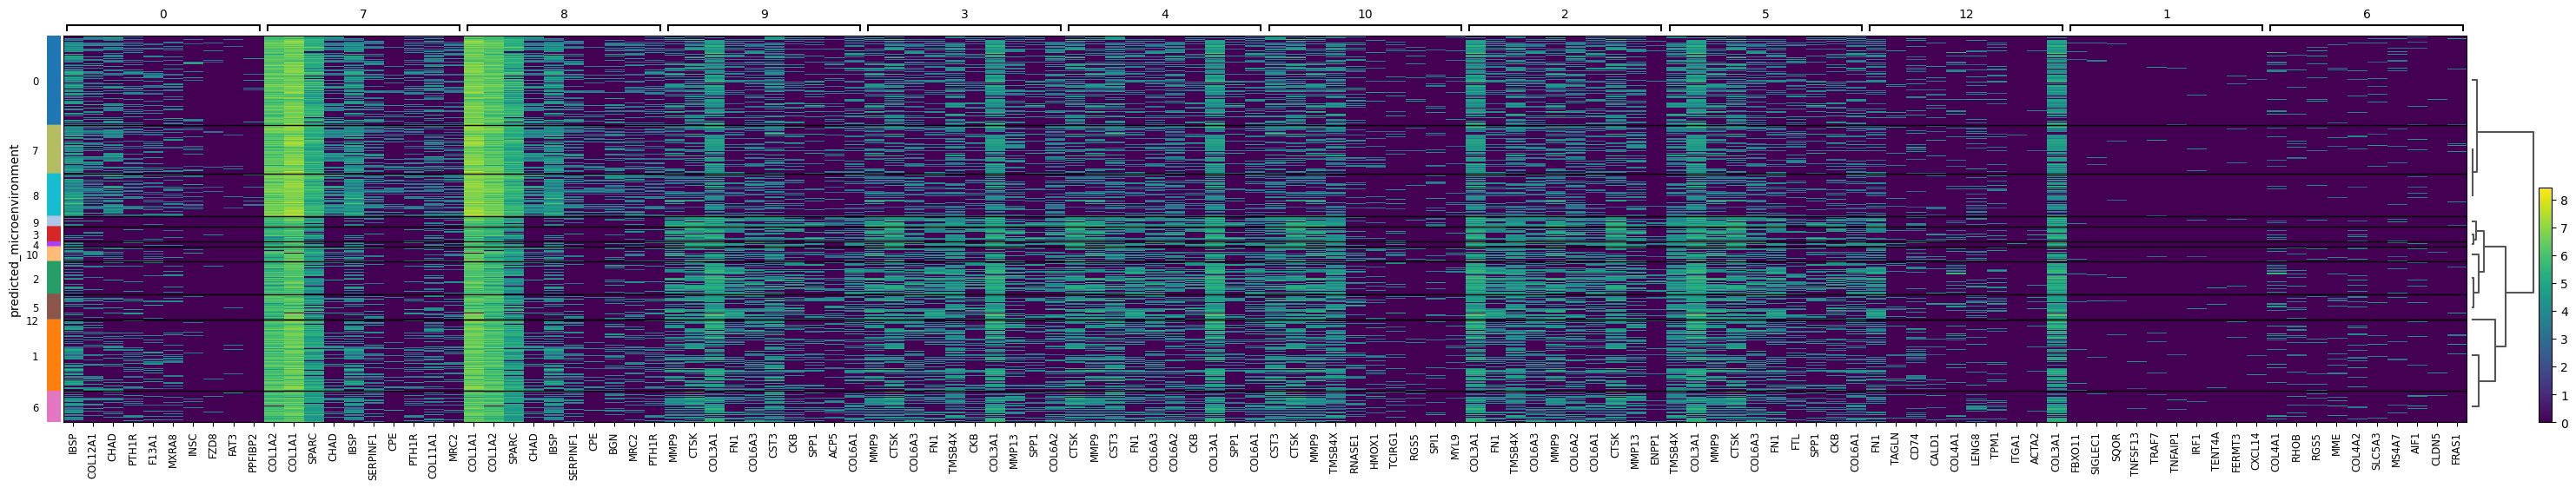


Generating dotplot for Tumor by predicted_microenvironment...


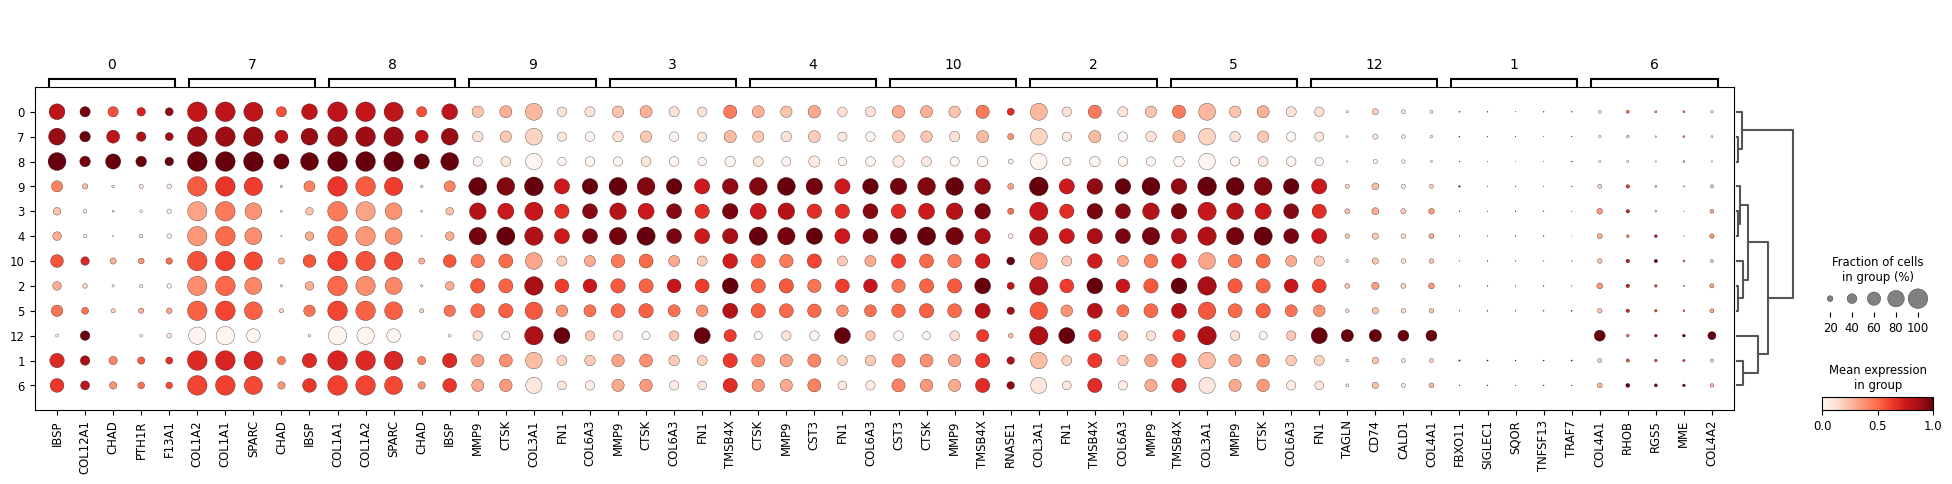


Analysis complete.


In [8]:
# Gene expression difference among clusters

print(f"Unique cell types in sp_adata: {sp_adata.obs['predicted_cell_type'].unique()}")
if target_cell_type not in sp_adata.obs['predicted_cell_type'].unique():
    print(f"Error: The specified target_cell_type '{target_cell_type}' is not found in sp_adata.obs['predicted_cell_type']. Please check the spelling or available cell types.")
sp_adata_filtered_by_celltype = sp_adata[sp_adata.obs['predicted_cell_type'] == target_cell_type].copy()

if sp_adata_filtered_by_celltype.n_obs == 0:
    print(f"Error: After filtering by '{target_cell_type}', no cells remain. This might be due to an incorrect cell type name or very sparse data.")

print(f"Analyzing {sp_adata_filtered_by_celltype.n_obs} cells for '{target_cell_type}'.")

sc.pp.normalize_total(sp_adata_filtered_by_celltype, target_sum=1e4)
sc.pp.log1p(sp_adata_filtered_by_celltype)

group_counts = sp_adata_filtered_by_celltype.obs['predicted_microenvironment'].value_counts()
# only microenvironment including >9 cells
valid_groups = group_counts[group_counts > 9].index.tolist()

if len(valid_groups) < 2:
    print("Error: Less than 2 valid groups with more than 1 cell.")
    print(f"Valid groups: {valid_groups}")
    exit()

sp_adata_filtered_by_celltype = sp_adata_filtered_by_celltype[sp_adata_filtered_by_celltype.obs['predicted_microenvironment'].isin(valid_groups)].copy()

# rank_genes_groups
key_added_for_rank_genes = f'rank_genes_groups_by_microenvironment_in_{target_cell_type}'
sc.tl.rank_genes_groups(
    sp_adata_filtered_by_celltype,
    groupby='predicted_microenvironment',
    method='wilcoxon',
    use_raw=False,
    key_added=key_added_for_rank_genes
)

# ----------------------------------------------------
# Visualizaion
# ----------------------------------------------------
print(f"\nDifferentially expressed genes for {target_cell_type} in each microenvironment:")
# 1. グループごとの細胞数をカウント
group_counts = sp_adata_filtered_by_celltype.obs['predicted_microenvironment'].value_counts()

# 2. 10細胞以上のグループのみを対象とする
valid_groups = [g for g in group_counts.index if group_counts[g] > 9]

# 3. rank_genes_groupsの結果を取得
result = sp_adata_filtered_by_celltype.uns[key_added_for_rank_genes]
groups = result['names'].dtype.names

# 4. 各グループについて、必要な情報をリストに格納
all_gene_data = []

for group in groups:
    if group not in valid_groups:
        continue  # <10細胞しかないグループはスキップ

    top_genes = result['names'][group][:10].tolist()
    top_scores = result['scores'][group][:10].tolist()
    top_pvals_adj = result['pvals_adj'][group][:10].tolist()

    for i in range(len(top_genes)):
        all_gene_data.append({
            'microenvironment': group,
            'gene_name': top_genes[i],
            'score': top_scores[i],
            'pvals_adj': top_pvals_adj[i]
        })

# 5. DataFrameに変換
gene_rank_df = pd.DataFrame(all_gene_data)
print(gene_rank_df)

# ヒートマップで可視化
print(f"\nGenerating heatmap for {target_cell_type} by predicted_microenvironment...")
sc.pl.rank_genes_groups_heatmap(
    sp_adata_filtered_by_celltype,
    groupby='predicted_microenvironment',
    key=key_added_for_rank_genes,
    n_genes=10,
    min_logfoldchange=0.5,
    show_gene_labels=True,
    use_raw=False,
    cmap='viridis',
    save=f'_{target_cell_type}_microenvironment_genes_heatmap.pdf'
)
plt.show()

# ドットプロット
print(f"\nGenerating dotplot for {target_cell_type} by predicted_microenvironment...")
sc.pl.rank_genes_groups_dotplot(
    sp_adata_filtered_by_celltype,
    groupby='predicted_microenvironment',
    key=key_added_for_rank_genes,
    n_genes=5,
    min_logfoldchange=0.5,
    standard_scale='var',
    save=f'_{target_cell_type}_microenvironment_genes_dotplot.pdf'
)
plt.show()

print("\nAnalysis complete.")
